## Predicting Heath Status using Prescription Data alone

##### Explore prescription data and merge with patient's health status table. I am building a supervised machine learning model to predict if patient has coexisting of hyperlipidemia and ischemia heart disease.

1. Select the eligibility of the patients
2. One hot encoding is used to make features
3. Cross validation
3. Build predictive model

In [1]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### Select patient eligibility

In [2]:
# import prescription data
df=pd.read_csv('Prescriptions.csv')

In [3]:
df.head(2)

,Patient_id,Prescription_date,drug_category,drug_group,drug_class
0,P23556,2016-05-08,Estrogens,Estrogens,Estrogens
1,P87538,2016-12-05,Antiparkinson and Related Therapy Agents,Antiparkinson Dopaminergics,Nonergoline Dopamine Receptor Agonists


In [4]:
# Unique patient numbers
df.Patient_id.nunique()

82546

In [5]:
# distinct drug class that were prescribed
df.drug_class.value_counts(normalize=True)

Hmg CoA Reductase Inhibitors                                4.945075e-02
Selective Serotonin Reuptake Inhibitors (SSRIs)             4.645962e-02
Thyroid Hormones                                            3.040734e-02
Combination Contraceptives - Oral                           2.991322e-02
Nonsteroidal Anti-Inflammatory Agents (NSAIDs)              2.477176e-02
Anticonvulsants - Misc.                                     2.425322e-02
Ace Inhibitors                                              2.388995e-02
Benzodiazepines                                             2.257749e-02
Biguanides                                                  2.093300e-02
Calcium Channel Blockers                                    1.995451e-02
Beta Blockers Cardio-Selective                              1.972991e-02
Proton Pump Inhibitors                                      1.878560e-02
Glucocorticosteroids                                        1.781004e-02
Antidepressants - Misc.                            

In [6]:
# Find the max and min prescription date for each patient
df_date = df.groupby(['Patient_id']).agg({'Prescription_date' : ['min', 'max']})
df_date.columns = ['_'.join(col) for col in df_date.columns]

In [7]:
# Create a column with day difference for the max and min date
df_date['day_diff']=(pd.to_datetime(df_date.Prescription_date_max) - pd.to_datetime(df_date.Prescription_date_min)).dt.days

In [8]:
df_date.head(2)

,Prescription_date_min,Prescription_date_max,day_diff
Patient_id,,,
P00001,2016-03-25,2016-03-25,0
P00002,2015-02-07,2015-12-26,322


In [9]:
# Select those patients having prescription drugs more than 100 days
df_tem=df_date.loc[df_date['day_diff'] >= 100]

In [10]:
# import table that has outcome variable
df2=pd.read_csv('patient_status.csv')

In [11]:
df2.head(2)

,Patient_id,health_status
0,Patient 00114,True
1,Patient 00183,True


In [12]:
# match the patient name with prescription data
df2['Patient_id']=df2['Patient_id'].str.replace('Patient ','P')

In [13]:
# set outcome variable name as 1 and 0
df2['health_status'].replace({False: 0, True: 1}, inplace=True)

In [14]:
# Merge dataframes of the two datasets
df_new=pd.merge(df_tem,df2,on='Patient_id',how='inner')

In [15]:
# Drop two columns from df_name
df_new = df_new.drop(columns=['Prescription_date_min', 'Prescription_date_max'])

In [16]:
# Ratio of patients without coexisting dieases and with coexisting dieases
df_new.health_status.value_counts(normalize=True)

0    0.991884
1    0.008116
Name: health_status, dtype: float64

##### Prepare features

In [17]:
# Make list of drugs that each patient take
df_drugs = df.groupby('Patient_id')['drug_class'].agg(lambda x:
                                                        list([y for y in x if y is not np.nan])).reset_index()

In [18]:
# Merge dataframes
df_all=pd.merge(df_drugs,df_new,on='Patient_id',how='inner')

In [19]:
df_all.head(2)

,Patient_id,drug_class,day_diff,health_status
0,P00002,"[Viral Vaccines, Viral Vaccines, Tetracyclines...",322,0
1,P00006,"[Thyroid Hormones, Thyroid Hormones, Thyroid H...",103,0


In [20]:
# Do dummy encoding for drug class
df_all=df_all.drop('drug_class', 1).join(df_all.drug_class.str.join('|').str.get_dummies())

In [21]:
# Create a new column to count the number of drugs each patient take
df_all['n_drugs']=df_all[df_all == 1].sum(axis=1)

In [22]:
df_all.head(2)

,Patient_id,day_diff,health_status,5-Alpha Reductase Inhibitors,5-HT3 Receptor Antagonists,5-Lipoxygenase Inhibitors,Ace Inhibitor & Calcium Channel Blocker Combinations,Ace Inhibitors,Ace Inhibitors & Thiazide/Thiazide-Like,Acne Antibiotics,...,Viscosupplements,Vitamin B-1,Vitamin B-6,Vitamin C,Vitamin D,Vitamin K,Wound Care - Growth Factor Agents,Wound Dressings,Xanthines,n_drugs
0,P00002,322,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0
1,P00006,103,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.0


##### Cross validation and find best subset of features

In [23]:
# Keep candidate features
X=df_all.drop(columns=['health_status','Patient_id'])

In [24]:
# outcome variable
y=df_all.health_status

In [25]:
# Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state=20)

In [26]:
# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [27]:
# Fitting Logistic Regression to the training set
classifier = LogisticRegression(class_weight='balanced')
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
# Apply recursive feature elimination with cross-validation to select the best number of features
# f1 is chosen as the scoring
rfecv = RFECV(estimator=classifier, step=1, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1), scoring='f1')
rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
      estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='warn', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='warn', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='f1', step=1, verbose=0)

In [29]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 515


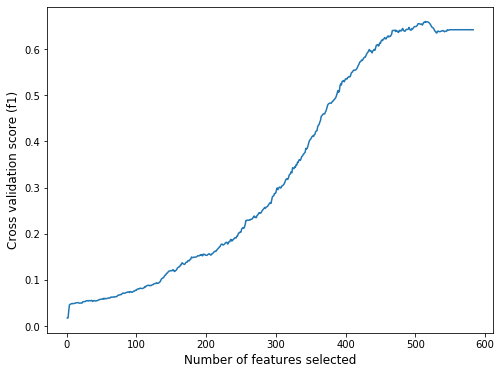

In [32]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(8,6))
plt.xlabel("Number of features selected", size=12)
plt.ylabel("Cross validation score (f1)", size=12)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [40]:
# Examples of some ranked features and scores
list_of_tuples = list(zip(rfecv.ranking_, rfecv.grid_scores_))
rf_df = pd.DataFrame(list_of_tuples, index=X.columns, columns=['Rank','Scores']).sort_values(by='Scores',ascending=False)
rf_df.head(10)

,Rank,Scores
Soluble Tumor Necrosis Factor Receptor Agents,1,0.660158
Sphingosine 1-Phosphate (S1P) Receptor Modulators,1,0.659249
Spacer/Aerosol-Holding Chambers & Supplies,1,0.659111
Somatostatic Agents,48,0.659111
Sodium-Glucose Co-Transporter 2 (SGLT2) Inhibitors,1,0.658931
Steroid Inhalants,1,0.658114
Sodium-Glucose Co-Transporter 2 Inhibitor-Biguanide Comb,1,0.657946
Sodium,1,0.657946
Steroid-Local Anesthetic Combinations,1,0.656997
Selective cGMP Phosphodiesterase Type 5 Inhibitors,1,0.655335


In [42]:
# select features
rfe = RFE(classifier, rfecv.n_features_, step=1)
rfe = rfe.fit(X_train, y_train.values.ravel())

##### Build the final predictive models using the 515 features to build the predictive the model

In [48]:
# Use the optimal subset of features to prepare for training
X_new=X.loc[:, rfe.support_]
y=df_all.health_status

In [49]:
# Splitting the dataset into the training set and test set
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size = 0.2, shuffle=True, random_state=22)

In [50]:
# Feature scaling
sc = StandardScaler()
X_train_new = sc.fit_transform(X_train_new)
X_test_new = sc.transform(X_test_new)

In [51]:
# Fitting logistic regression to the new training set
lr=LogisticRegression(class_weight='balanced', random_state=2)
lr.fit(X_train_new, y_train_new)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=2, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
# Predicting the test set results
y_pred_new = lr.predict(X_test_new)

In [55]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_new, y_pred_new)
pd.crosstab(y_test_new, y_pred_new, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,7248,26,7274
1,9,61,70
All,7257,87,7344


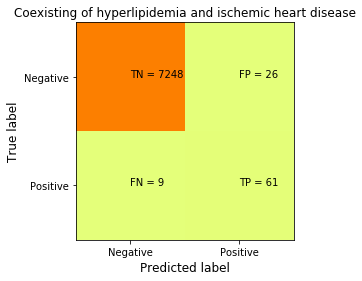

In [56]:
# Plot a confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test_new,y_pred_new)
plt.clf()
plt.imshow(cm,cmap=plt.cm.Wistia)
names=['Negative','Positive']
plt.title('Coexisting of hyperlipidemia and ischemic heart disease')
plt.ylabel('True label', size=12)
plt.xlabel('Predicted label', size=12)
tick_marks=np.arange(len(names))
plt.xticks(tick_marks,names)
plt.yticks(tick_marks,names)
s=[['TN','FP'],['FN','TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i,str(s[i][j]+" = "+str(cm[i][j])))
plt.show()

In [57]:
# Some validation metrics
# accuracy: (tp + tn) / (p + n)
balanced_accuracy = balanced_accuracy_score(y_test_new, y_pred_new)
print('Balanced accuracy: %f' % balanced_accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_new, y_pred_new)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_new, y_pred_new)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_new, y_pred_new)
print('F1 score: %f' % f1)

Balanced accuracy: 0.933927
Precision: 0.701149
Recall: 0.871429
F1 score: 0.777070


Conclusion: With a patient's prescription data, I am able to apply a logistic regression model to predict the coexisting of hyperlipidemia and ischemic heart disease among patients. Cross validation was done on the training data and best feature set was selected for achieving the optimal outcome.  